1\. **Maximum wind speed prediction at the Sprogø station**

The exercise goal is to predict the maximum wind speed occurring every 50 years even if no measure exists for such a period. The available data are only measured over 21 years at the Sprogø meteorological station located in Denmark. 

The annual maxima are supposed to fit a normal probability density function. However such function is not going to be estimated because it gives a probability from a wind speed maxima. Finding the maximum wind speed occurring every 50 years requires the opposite approach, the result needs to be found from a defined probability. That is the quantile function role and the exercise goal will be to find it. In the current model, it is supposed that the maximum wind speed occurring every 50 years is defined as the upper 2% quantile.

By definition, the quantile function is the inverse of the cumulative distribution function. The latter describes the probability distribution of an annual maxima. In the exercise, the cumulative probability $p_i$ for a given year i is defined as $p_i = i/(N+1)$ with $N = 21$, the number of measured years. Thus it will be possible to calculate the cumulative probability of every measured wind speed maxima. From those experimental points, the scipy.interpolate module will be very useful for fitting the quantile function. Finally the 50 years maxima is going to be evaluated from the cumulative probability of the 2% quantile.

Practically, load the dataset:

```python
import numpy as np
max_speeds = np.load('max-speeds.npy')
years_nb = max_speeds.shape[0]
```

Compute then the cumulative probability $p_i$ (`cprob`) and sort the maximum speeds from the data. Use then the  UnivariateSpline from scipy.interpolate to define a quantile function and thus estimate the probabilities.

In the current model, the maximum wind speed occurring every 50 years is defined as the upper 2% quantile. As a result, the cumulative probability value will be:

```python
fifty_prob = 1. - 0.02
```

So the storm wind speed occurring every 50 years can be guessed as:

``` python
fifty_wind = quantile_func(fifty_prob)
```



2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18

min: -62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58

* Plot these temperature extremes.
* Define a function that can describe min and max temperatures. 
* Fit this function to the data with scipy.optimize.curve_fit().
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

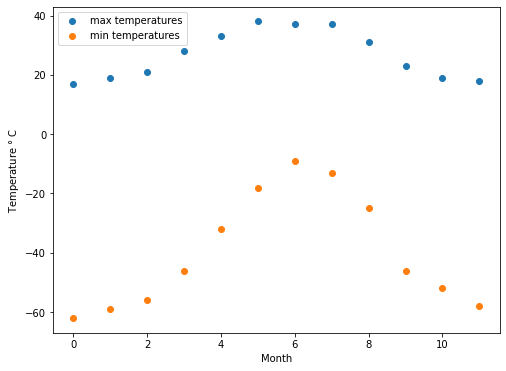

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 

# max e min sono temperature per ciascun mese 
temperatures = {'max': [17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18],
'min': [-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58]}
plt.scatter(np.arange(len(temperatures['max'])), np.array(temperatures['max']), label='max temperatures')
plt.scatter(np.arange(len(temperatures['min'])), np.array(temperatures['min']), label='min temperatures')
plt.gcf().set_size_inches((8, 6)) 
plt.xlabel('Month')
plt.ylabel('Temperature $\degree$ C')
plt.legend()
# così rappresento i due set come se fossero diversi ma in realtà vorrei una funzione in grado di stimare l'andamento di entrambe, come una gaussiana modulata da un seno.
# Oppure, poichè mi aspetto una funzione periodica potrei pensare 


time offset min vs max (fit sinusoidale) è 4.16608435420111 4.4645295072813225
time offset min vs max (fit gaussiano) è 6.164525919157583 5.735815088206074


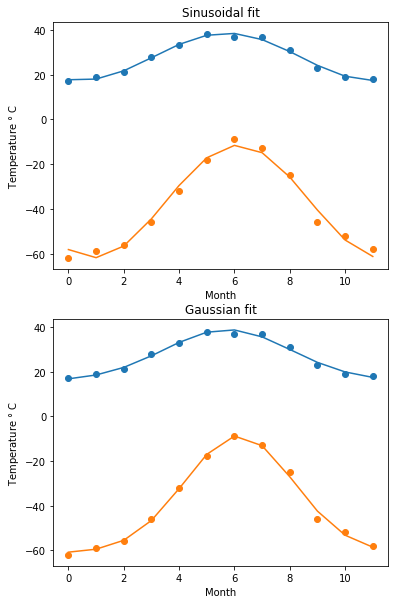

In [15]:
# definisco una funzione che sia un seno modulato nel tempo da un'altra funzione periodica come un coseno.
# Mi aspetto di trovare soltanto un periodo (un anno) della funzione 
# def func(x,a,b,c,d) : 
    # return np.sin(a*x+b)*np.cos(c*x+d)
# In realtà se avessimo dati distribuiti in più anni allora potremmo osservare la manifestazione della periodicità del fenomeno (alternarsi periodico delle stagioni). Tuttavia in questo caso abbiamo un solo anno dunque possiamo usare due tipologie di fit: uno gaussiano e uno sinusoidale per i due set separatamente e non insieme come avrei fatto nel caso precedente.
from scipy.optimize import curve_fit

def sinusoid(x,a,b,c,d) :
    return a*np.sin(b*x+c)+d
    
def gaussian(x,a,b,c,d) :
    return a*np.exp(-b*(x-c)**2)+d
# i quattro parametri rappresentano lo scaling e la traslazione orizzontali e verticali 
x_data = np.arange(len(temperatures['max']))
y_datamax = np.array(temperatures['max'])
y_datamin = np.array(temperatures['min'])

popts_max, pcovs_max = curve_fit(sinusoid, x_data, y_datamax, p0=[30,2*np.pi/12,4,-30])
popts_min, pcovs_min = curve_fit(sinusoid, x_data, y_datamin, p0=[10,2*np.pi/12,4,30])
poptg_max, pcovg_max = curve_fit(gaussian, x_data, y_datamax, p0=[60,1/np.sqrt(2),6,-60])
poptg_min, pcovg_min = curve_fit(gaussian, x_data, y_datamin, p0=[20,1/np.sqrt(2),6,-60])

fig, (ax1,ax2) = plt.subplots(2, 1, figsize = (6,10))
ax1.set_ylabel('Temperature $\degree$ C')
ax1.set_xlabel('Month')
ax1.set_title('Sinusoidal fit')
ax2.set_ylabel('Temperature $\degree$ C')
ax2.set_xlabel('Month')
ax2.set_title('Gaussian fit')
ax1.scatter(x_data, y_datamax)
ax1.plot(x_data, sinusoid(x_data, *popts_max))
ax1.scatter(x_data, y_datamin)
ax1.plot(x_data, sinusoid(x_data, *popts_min))
ax2.scatter(x_data, y_datamax)
ax2.plot(x_data, gaussian(x_data, *poptg_max))
ax2.scatter(x_data, y_datamin)
ax2.plot(x_data, gaussian(x_data, *poptg_min))
print('time offset min vs max (fit sinusoidale) è', popts_min[2], popts_max[2]) # entrambi circa 4
print('time offset min vs max (fit gaussiano) è', poptg_min[2], poptg_max[2]) # entrambi circa 6

3\. **2D minimization of a six-hump camelback function**

$$
f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2
$$

has multiple global and local minima. Find the global minima of this function.

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use numpy.meshgrid() and pylab.imshow() to find visually the regions.
* Use scipy.optimize.minimize(), optionally trying out several of its methods.

How many global minima are there, and what is the function value at those points? What happens for an initial guess of $(x, y) = (0, 0)$ ?


4\. **FFT of a simple dataset**

Performe a periodicity analysis on the lynxs-hares population

5\. **FFT of an image**

* Examine the provided image `moonlanding.png`, which is heavily contaminated with periodic noise. In this exercise, we aim to clean up the noise using the Fast Fourier Transform.
* Load the image using pylab.imread().
* Find and use the 2-D FFT function in scipy.fftpack, and plot the spectrum (Fourier transform of) the image. Do you have any trouble visualising the spectrum? If so, why?
* The spectrum consists of high and low frequency components. The noise is contained in the high-frequency part of the spectrum, so set some of those components to zero (use array slicing).
* Apply the inverse Fourier transform to see the resulting image.